## Import Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

## Load Cleaned Data

In [43]:
df_clean = pd.read_csv('../data/cleaned/earthquake_japan_cleaned.csv')
print("Data loaded successfully.")
print(df_clean.shape)

Data loaded successfully.
(33527, 17)


In [44]:
df_clean.head()

,latitude,longitude,depth,mag,nst,gap,rms,depthError,magNst,month,day,hour,depth_rms,data_quality_index,M_ML,M_Mb,M_Ms
0,36.417,140.568,67.9,4.8,32.0,122.6,1.2,6.5,12.0,1,1,9,81.48,147.12,0,1,0
1,35.457,141.272,10.0,4.3,32.0,122.6,1.1,6.9,1.0,1,3,8,11.00,134.86,0,1,0
2,36.342,141.408,55.1,4.4,32.0,122.6,1.1,11.8,4.0,1,4,12,60.61,134.86,0,1,0
3,32.381,138.821,247.7,5.2,32.0,122.6,0.9,3.6,10.0,1,4,23,222.93,110.34,0,0,0
4,36.123,144.047,33.0,4.3,32.0,122.6,1.1,6.9,1.0,1,5,20,36.30,134.86,0,1,0


## Define Features and Target


In [45]:
target = 'mag'
X = df_clean.drop(columns=[target])
y = df_clean[target]

print(f"Features (X): {X.shape[1]} columns")
print(f"Target (y): {y.name}")

Features (X): 16 columns
Target (y): mag


## Train/Test Split

In [46]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 26821
Test set size: 6706


## Train Random Forest Model

In [47]:
## Hyperparameter Tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_samples': [0.8, 0.9, None]
}

# Base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Random search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found:")
print(random_search.best_params_)

# Use the best model
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Best parameters found:
{'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_samples': None, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


## Make Predictions

In [48]:
y_pred = best_rf.predict(X_test)

comparison = pd.DataFrame({
    'Actual': y_test.values[:100],
    'Predicted': y_pred[:100]
})

print(comparison)

    Actual  Predicted
0      5.2   5.378964
1      5.6   5.778919
2      4.0   4.290203
3      4.9   4.765513
4      5.0   4.761948
..     ...        ...
95     4.5   4.542501
96     4.5   4.357053
97     4.6   4.522311
98     3.3   4.072816
99     4.5   4.255816

[100 rows x 2 columns]


## Evaluate the Model

Random Forest - Performance Metrics
  MAE  : 0.175
  RMSE : 0.236
  R²   : 0.737


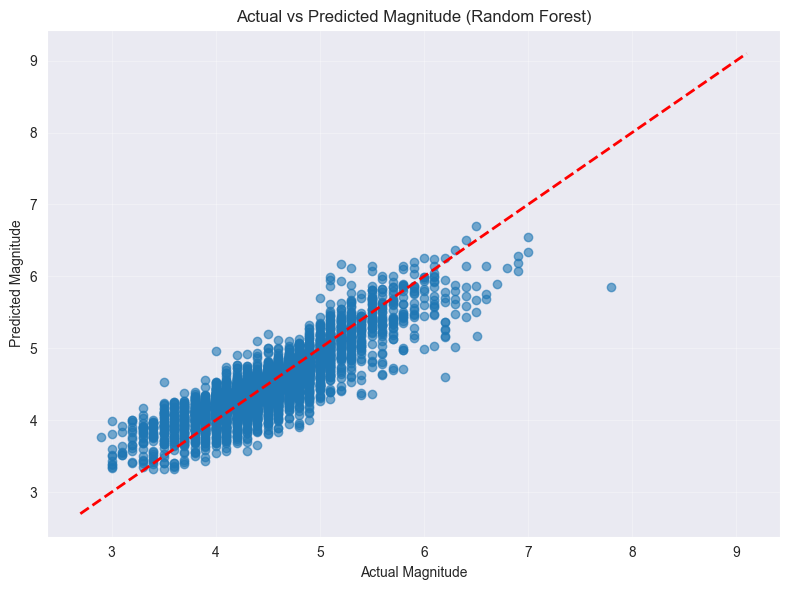

In [56]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest - Performance Metrics")
print(f"  MAE  : {mae:.3f}")
print(f"  RMSE : {rmse:.3f}")
print(f"  R²   : {r2:.3f}")

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs Predicted Magnitude (Random Forest)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/rf_actual_vs_predicted.png', dpi=300)
plt.show()

## Feature Importance

🔝 Top 10 Most Important Features:
               feature  importance
3                  nst    0.272269
7               magNst    0.176812
4                  gap    0.157399
14                M_Mb    0.068607
12  data_quality_index    0.064046
2                depth    0.050135
6           depthError    0.046094
11           depth_rms    0.040639
5                  rms    0.030403
1            longitude    0.025777
0             latitude    0.023952
8                month    0.013936
9                  day    0.012973
10                hour    0.011576
15                M_Ms    0.003129
13                M_ML    0.002254


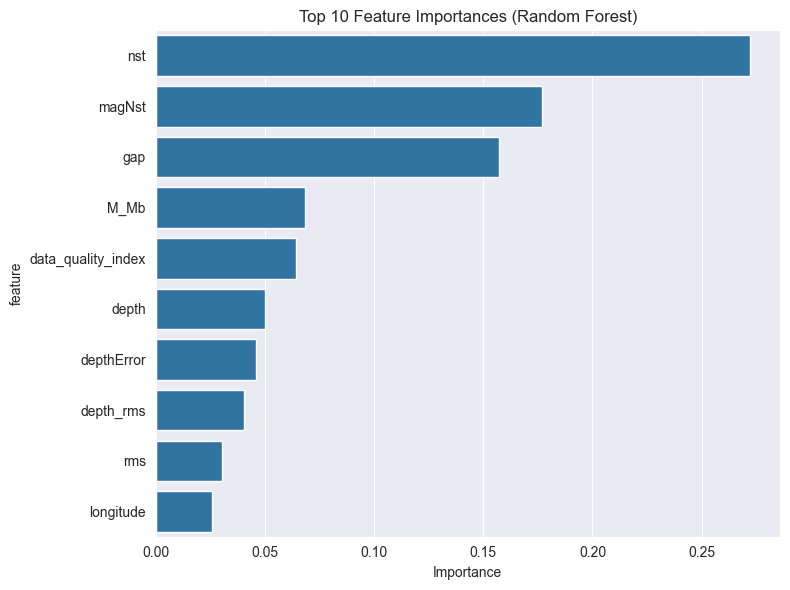

In [52]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 10
print("🔝 Top 10 Most Important Features:")
print(importance_df.head(20))

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../plots/rf_feature_importance.png', dpi=300)
plt.show()

# Save importance to CSV
importance_df.to_csv('../outputs/rf_feature_importance.csv', index=False)

## Save the Trained Model

In [58]:
y# Ensure directory exists
os.makedirs('../models', exist_ok=True)

# Save model
joblib.dump(rf_model, '../models/rf_earthquake_model.pkl')

print("Model saved to '../models/rf_earthquake_model.pkl'")

Model saved to '../models/rf_earthquake_model.pkl'


## Test Cases: this is exatra parts

In [61]:
# # Debug: What did the model learn?
# print("Features used during training (in order):")
# print(list(X_train.columns))

Features used during training (in order):
['latitude', 'longitude', 'depth', 'nst', 'gap', 'rms', 'depthError', 'magNst', 'month', 'day', 'hour', 'depth_rms', 'data_quality_index', 'M_ML', 'M_Mb', 'M_Ms']


In [64]:
# ## 🔎 Extended Test: 5 Realistic Japan Earthquakes
# # Define more test cases across Japan
# test_cases = pd.DataFrame([
#     # 1. Shallow inland (Kansai region) - likely moderate quake
#     {
#         'latitude': 34.7, 'longitude': 135.5,  # Osaka area
#         'depth': 8.0, 'rms': 0.25, 'gap': 40, 'nst': 30, 'magNst': 35,
#         'depthError': 0.9, 'month': 5, 'day': 12, 'hour': 9,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 0  # M (moment)
#     },
#     # 2. Deep subduction (Tohoku offshore) - large potential
#     {
#         'latitude': 38.5, 'longitude': 143.0,  # Near Japan Trench
#         'depth': 60.0, 'rms': 0.7, 'gap': 70, 'nst': 20, 'magNst': 25,
#         'depthError': 2.5, 'month': 3, 'day': 11, 'hour': 14,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 1  # Ms type
#     },
#     # 3. Very deep (Izu-Bonin arc)
#     {
#         'latitude': 30.0, 'longitude': 140.0,  # South of Tokyo
#         'depth': 300.0, 'rms': 1.5, 'gap': 120, 'nst': 10, 'magNst': 12,
#         'depthError': 8.0, 'month': 8, 'day': 20, 'hour': 22,
#         'M_ML': 1, 'M_Mb': 0, 'M_Ms': 0  # ML type
#     },
#     # 4. Shallow, high-quality (Kanto/Tokyo area)
#     {
#         'latitude': 35.6, 'longitude': 139.7,
#         'depth': 12.0, 'rms': 0.15, 'gap': 35, 'nst': 40, 'magNst': 50,
#         'depthError': 0.7, 'month': 1, 'day': 15, 'hour': 10,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 0
#     },
#     # 5. Moderate, poor data (remote area)
#     {
#         'latitude': 43.0, 'longitude': 141.0,  # Hokkaido
#         'depth': 25.0, 'rms': 2.0, 'gap': 180, 'nst': 6, 'magNst': 8,
#         'depthError': 6.0, 'month': 12, 'day': 5, 'hour': 3,
#         'M_ML': 0, 'M_Mb': 1, 'M_Ms': 0  # Mb type
#     }
# ])
#
# # Add engineered features
# test_cases['depth_rms'] = test_cases['depth'] * test_cases['rms']
# test_cases['data_quality_index'] = test_cases['rms'] * test_cases['gap']
#
# # Use exact training feature order
# feature_columns = list(X_train.columns)
# X_test = test_cases[feature_columns]
#
# # Predict
# y_pred = best_rf.predict(X_test)
# test_cases['predicted_mag'] = y_pred
#
# # Show results
# print("📍 Predictions for 5 Japan Earthquake Scenarios")
# print("================================================")
# print(test_cases[['latitude', 'longitude', 'depth', 'rms', 'nst', 'predicted_mag']].round(2))

📍 Predictions for 5 Japan Earthquake Scenarios
   latitude  longitude  depth   rms  nst  predicted_mag
0      34.7      135.5    8.0  0.25   30           5.14
1      38.5      143.0   60.0  0.70   20           4.63
2      30.0      140.0  300.0  1.50   10           3.92
3      35.6      139.7   12.0  0.15   40           5.52
4      43.0      141.0   25.0  2.00    6           4.16


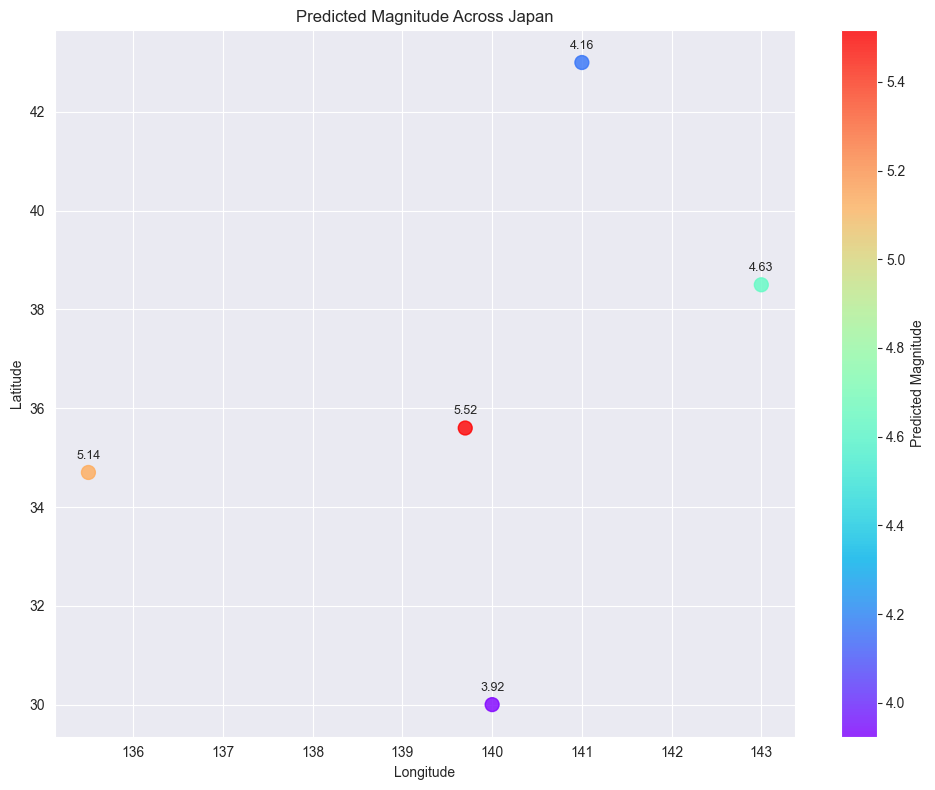

In [65]:
# import matplotlib.pyplot as plt
#
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(test_cases['longitude'], test_cases['latitude'],
#                       c=test_cases['predicted_mag'], s=100, cmap='rainbow', alpha=0.8)
# plt.colorbar(scatter, label='Predicted Magnitude')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Predicted Magnitude Across Japan')
# for i, row in test_cases.iterrows():
#     plt.annotate(f"{row['predicted_mag']:.2f}",
#                  (row['longitude'], row['latitude']),
#                  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
# plt.tight_layout()
# plt.savefig('../plots/japan_magnitude_predictions.png', dpi=300)
# plt.show()

In [66]:
# ## 🔎 Extended Test: 6 Realistic Japan Earthquakes (Including 2011 Tohoku)
# # Define test cases
# test_cases = pd.DataFrame([
#     # 1. Shallow inland (Kansai region)
#     {
#         'latitude': 34.7, 'longitude': 135.5,
#         'depth': 8.0, 'rms': 0.25, 'gap': 40, 'nst': 30, 'magNst': 35,
#         'depthError': 0.9, 'month': 5, 'day': 12, 'hour': 9,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 0
#     },
#     # 2. Deep subduction (Tohoku offshore)
#     {
#         'latitude': 38.5, 'longitude': 143.0,
#         'depth': 60.0, 'rms': 0.7, 'gap': 70, 'nst': 20, 'magNst': 25,
#         'depthError': 2.5, 'month': 3, 'day': 11, 'hour': 14,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 1
#     },
#     # 3. Very deep (Izu-Bonin arc)
#     {
#         'latitude': 30.0, 'longitude': 140.0,
#         'depth': 300.0, 'rms': 1.5, 'gap': 120, 'nst': 10, 'magNst': 12,
#         'depthError': 8.0, 'month': 8, 'day': 20, 'hour': 22,
#         'M_ML': 1, 'M_Mb': 0, 'M_Ms': 0
#     },
#     # 4. Shallow, high-quality (Tokyo area)
#     {
#         'latitude': 35.6, 'longitude': 139.7,
#         'depth': 12.0, 'rms': 0.15, 'gap': 35, 'nst': 40, 'magNst': 50,
#         'depthError': 0.7, 'month': 1, 'day': 15, 'hour': 10,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 0
#     },
#     # 5. Moderate, poor data (Hokkaido)
#     {
#         'latitude': 43.0, 'longitude': 141.0,
#         'depth': 25.0, 'rms': 2.0, 'gap': 180, 'nst': 6, 'magNst': 8,
#         'depthError': 6.0, 'month': 12, 'day': 5, 'hour': 3,
#         'M_ML': 0, 'M_Mb': 1, 'M_Ms': 0
#     },
#     # 6. 🌊 2011 Tohoku Earthquake (Realistic Simulation)
#     {
#         'latitude': 38.3, 'longitude': 142.4,  # Epicenter near Honshu east coast
#         'depth': 24.0, 'rms': 0.35, 'gap': 20, 'nst': 120, 'magNst': 150,
#         'depthError': 1.0, 'month': 3, 'day': 11, 'hour': 14,
#         'M_ML': 0, 'M_Mb': 0, 'M_Ms': 0  # Moment magnitude (Mw) → M group
#     }
# ])
#
# # Add engineered features
# test_cases['depth_rms'] = test_cases['depth'] * test_cases['rms']
# test_cases['data_quality_index'] = test_cases['rms'] * test_cases['gap']
#
# # Use exact training feature order
# feature_columns = list(X_train.columns)
# X_test = test_cases[feature_columns]
#
# # Predict
# y_pred = best_rf.predict(X_test)
# test_cases['predicted_mag'] = y_pred
#
# # Show results
# print("📍 Predictions for 6 Japan Earthquake Scenarios (Including 2011 Tohoku)")
# print("=====================================================================")
# print(test_cases[['latitude', 'longitude', 'depth', 'rms', 'nst', 'predicted_mag']].round(2))

📍 Predictions for 6 Japan Earthquake Scenarios (Including 2011 Tohoku)
   latitude  longitude  depth   rms  nst  predicted_mag
0      34.7      135.5    8.0  0.25   30           5.14
1      38.5      143.0   60.0  0.70   20           4.63
2      30.0      140.0  300.0  1.50   10           3.92
3      35.6      139.7   12.0  0.15   40           5.52
4      43.0      141.0   25.0  2.00    6           4.16
5      38.3      142.4   24.0  0.35  120           5.75


In [69]:
# # Extract the actual Tohoku row
# tohoku_row = df_clean[df_clean['mag'] == 9.1].copy()
#
# # Add engineered features
# tohoku_row['depth_rms'] = tohoku_row['depth'] * tohoku_row['rms']
# tohoku_row['data_quality_index'] = tohoku_row['rms'] * tohoku_row['gap']
#
# # Select only the features used in training
# X_tohoku = tohoku_row[X_train.columns]  # Match training columns
#
# # Predict what the model thinks the magnitude should be
# predicted_for_actual = best_rf.predict(X_tohoku)[0]
#
# print(f"🎯 Actual magnitude: 9.10")
# print(f"📉 Model's prediction for the *actual* Tohoku quake: {predicted_for_actual:.2f}")

🎯 Actual magnitude: 9.10
📉 Model's prediction for the *actual* Tohoku quake: 7.46


In [70]:
# from xgboost import XGBRegressor
#
# xgb = XGBRegressor(
#     n_estimators=300,
#     max_depth=8,
#     learning_rate=0.05,
#     subsample=0.9,
#     colsample_bytree=0.8,
#     random_state=42
# )
#
# xgb.fit(X_train, y_train)
#
# # Predict for actual Tohoku
# xgb_pred = xgb.predict(X_tohoku)[0]
# print(f"XGBoost prediction for actual Tohoku: {xgb_pred:.2f}")

XGBoost prediction for actual Tohoku: 8.83
